# Dataset data analysis

In [1]:
import pandas as pandas
import matplotlib.pyplot as plt
import string
import os
punctuations_list = string.punctuation

### Data loading

#### Read both data files.
Note: The file wiki-auto-part-2-data.json has no sentence_alignments, while the wiki-auto-part-1-data.json has sentence_alignment and paragraph_alignment

In [2]:
%%time
dataset_cols_df_wiki_part_1 = ['simple', 'normal', 'sentence_alignment','paragraph_alignment']
df_wiki_part_1 = pandas.read_json(
    'data/wiki-auto-part-1-data.json',
    encoding='utf8',
    orient='index'
)
# Convert the list of lists sentence_alignment and paragraph_alignment into a list of tuples
df_wiki_part_1.sentence_alignment = df_wiki_part_1.sentence_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_1.paragraph_alignment = df_wiki_part_1.paragraph_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_1.head(10)

CPU times: user 11.2 s, sys: 5.56 s, total: 16.8 s
Wall time: 19.5 s


,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 702227, 'title': 'Lata Mondal', 'url': ...","{'id': 41918715, 'title': 'Lata Mondal', 'url'...","[(simple-702227-0-0, normal-41918715-0-0), (si...","[(simple-702227-0, normal-41918715-0)]"
1,"{'id': 697879, 'title': 'Tuulikki Ukkola', 'ur...","{'id': 60918445, 'title': 'Tuulikki Ukkola', '...","[(simple-697879-0-0, normal-60918445-0-0), (si...","[(simple-697879-0, normal-60918445-0), (simple..."
2,"{'id': 120452, 'title': 'Kot Sarang', 'url': '...","{'id': 14570332, 'title': 'Kot Sarang', 'url':...","[(simple-120452-0-0, normal-14570332-0-0)]","[(simple-120452-0, normal-14570332-0)]"
3,"{'id': 276895, 'title': 'Elisabeth Charlotte o...","{'id': 946890, 'title': 'Elizabeth Charlotte, ...","[(simple-276895-0-0, normal-946890-0-0), (simp...","[(simple-276895-0, normal-946890-0), (simple-2..."
4,"{'id': 697649, 'title': 'Rory Stewart', 'url':...","{'id': 2656347, 'title': 'Rory Stewart', 'url'...","[(simple-697649-0-0, normal-2656347-0-0), (sim...","[(simple-697649-0, normal-2656347-0), (simple-..."
5,"{'id': 413275, 'title': 'Not Without My Daught...","{'id': 1808380, 'title': 'Not Without My Daugh...","[(simple-413275-0-0, normal-1808380-0-0), (sim...","[(simple-413275-0, normal-1808380-0)]"
6,"{'id': 256064, 'title': 'NBC Symphony Orchestr...","{'id': 150698, 'title': 'NBC Symphony Orchestr...","[(simple-256064-0-0, normal-150698-0-0), (simp...","[(simple-256064-0, normal-150698-0)]"
7,"{'id': 516259, 'title': 'Priyanka Chopra', 'ur...","{'id': 838950, 'title': 'Priyanka Chopra', 'ur...","[(simple-516259-0-0, normal-838950-0-0), (simp...","[(simple-516259-0, normal-838950-0), (simple-5..."
8,"{'id': 103132, 'title': 'Michigan Internationa...","{'id': 966394, 'title': 'Michigan Internationa...","[(simple-103132-0-0, normal-966394-0-0), (simp...","[(simple-103132-0, normal-966394-0), (simple-1..."
9,"{'id': 425394, 'title': 'Loneliness', 'url': '...","{'id': 1570429, 'title': 'Loneliness', 'url': ...","[(simple-425394-0-0, normal-1570429-0-0), (sim...","[(simple-425394-0, normal-1570429-0), (simple-..."


In [3]:
%%time
dataset_cols_df_wiki_part_2 = ['simple', 'normal', 'sentence_alignment']
df_wiki_part_2 = pandas.read_json(
    'data/wiki-auto-part-2-data.json',
    encoding='utf8',
    orient='index'
)
# add new column to the dataset to make similar to the first dataset
df_wiki_part_2['paragraph_alignment'] = [[] for _ in range(df_wiki_part_2.shape[0])]
# Convert the list of lists sentence_alignment and paragraph_alignment into a list of tuples
df_wiki_part_2.sentence_alignment = df_wiki_part_2.sentence_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list if len(alignment_list)> 0])
df_wiki_part_2.paragraph_alignment = df_wiki_part_2.paragraph_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list if len(alignment_list)> 0])
df_wiki_part_2.head(10)

CPU times: user 512 ms, sys: 266 ms, total: 778 ms
Wall time: 882 ms


,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 78856, 'title': 'Vex, Switzerland', 'ur...","{'id': 7023314, 'title': 'Vex, Switzerland', '...",[],[]
1,"{'id': 193292, 'title': 'South Portland, Maine...","{'id': 115950, 'title': 'South Portland, Maine...",[],[]
2,"{'id': 195874, 'title': 'Kosuke Suda', 'url': ...","{'id': 18746548, 'title': 'Kosuke Suda', 'url'...",[],[]
3,"{'id': 608316, 'title': 'Cheng Lim LRT Station...","{'id': 3490013, 'title': 'Cheng Lim LRT statio...",[],[]
4,"{'id': 684573, 'title': 'Swifton, Arkansas', '...","{'id': 107051, 'title': 'Swifton, Arkansas', '...",[],[]
5,"{'id': 152877, 'title': 'Burley, Idaho', 'url'...","{'id': 110663, 'title': 'Burley, Idaho', 'url'...",[],[]
6,"{'id': 200958, 'title': 'S.S.D. Licata 1931', ...","{'id': 6968112, 'title': 'A.S.D. Licata 1931',...",[],[]
7,"{'id': 519888, 'title': 'Vivian, Louisiana', '...","{'id': 115518, 'title': 'Vivian, Louisiana', '...",[],[]
8,"{'id': 342309, 'title': '201 BC', 'url': 'http...","{'id': 60498, 'title': '201 BC', 'url': 'https...",[],[]
9,"{'id': 164901, 'title': 'Saint-Lys', 'url': 'h...","{'id': 8104124, 'title': 'Saint-Lys', 'url': '...",[],[]


In [4]:
print("# of paired articles for wiki part-2", len(df_wiki_part_2))
print("# of paired articles with alignments for wiki part-2", sum(map(lambda sentence_alignment: len(sentence_alignment)> 0, df_wiki_part_2.sentence_alignment)))
print("# of paired articles for wiki part-1 ", len(df_wiki_part_1))
print("# of paired articles with alignments for wiki part-1 ", sum(map(lambda sentence_alignment: len(sentence_alignment)> 0, df_wiki_part_1.sentence_alignment)))

# of paired articles for wiki part-2 13036
# of paired articles with alignments for wiki part-2 970
# of paired articles for wiki part-1  125059
# of paired articles with alignments for wiki part-1  121840


# Concatenate both dataframes

In [4]:
df_dataset = pandas.concat([df_wiki_part_1,df_wiki_part_2])
df_dataset.reset_index(drop=True,inplace=True)
display(df_dataset)
# verify the length of the newly created dataframe to be len(df_wiki_part_2)+len(df_wiki_part_1)
print(len(df_wiki_part_2)+len(df_wiki_part_1))
print(len(df_dataset))

,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 702227, 'title': 'Lata Mondal', 'url': ...","{'id': 41918715, 'title': 'Lata Mondal', 'url'...","[(simple-702227-0-0, normal-41918715-0-0), (si...","[(simple-702227-0, normal-41918715-0)]"
1,"{'id': 697879, 'title': 'Tuulikki Ukkola', 'ur...","{'id': 60918445, 'title': 'Tuulikki Ukkola', '...","[(simple-697879-0-0, normal-60918445-0-0), (si...","[(simple-697879-0, normal-60918445-0), (simple..."
2,"{'id': 120452, 'title': 'Kot Sarang', 'url': '...","{'id': 14570332, 'title': 'Kot Sarang', 'url':...","[(simple-120452-0-0, normal-14570332-0-0)]","[(simple-120452-0, normal-14570332-0)]"
3,"{'id': 276895, 'title': 'Elisabeth Charlotte o...","{'id': 946890, 'title': 'Elizabeth Charlotte, ...","[(simple-276895-0-0, normal-946890-0-0), (simp...","[(simple-276895-0, normal-946890-0), (simple-2..."
4,"{'id': 697649, 'title': 'Rory Stewart', 'url':...","{'id': 2656347, 'title': 'Rory Stewart', 'url'...","[(simple-697649-0-0, normal-2656347-0-0), (sim...","[(simple-697649-0, normal-2656347-0), (simple-..."
...,...,...,...,...
138090,"{'id': 158778, 'title': 'Marcilly-le-Hayer', '...","{'id': 15432782, 'title': 'Marcilly-le-Hayer',...",[],[]
138091,"{'id': 83891, 'title': 'Geltwil', 'url': 'http...","{'id': 6035836, 'title': 'Geltwil', 'url': 'ht...",[],[]
138092,"{'id': 248454, 'title': 'Koichi Hashimoto', 'u...","{'id': 36078529, 'title': 'Koichi Hashimoto (f...",[],[]
138093,"{'id': 156264, 'title': 'Calmar, Iowa', 'url':...","{'id': 114348, 'title': 'Calmar, Iowa', 'url':...",[],[]


138095
138095


### Piechart to show the percentage

In [30]:
print("# of paired articles for df_dataset ", len(df_dataset))
print("# of paired articles with alignments for wiki df_dataset", sum(map(lambda sentence_alignment: len(sentence_alignment)> 0, df_dataset.sentence_alignment)))
print("Total # of simpled sentences ", sum(map(lambda content: len(content['content']), df_dataset.simple))) 
print("Total # of Normal sentences ", sum(map(lambda content: len(content['content']), df_dataset.normal)))

# of paired articles for df_dataset  138095
# of paired articles with alignments for wiki df_dataset 122810
Total # of simpled sentences  1241671
Total # of Normal sentences  10144476


In [5]:
'''
The alignments between the simplified and the normal (original) sentences are saved in the sentence_alignment and/or in the paragraph_alignment field/column.
 (a) If the paragraph_alignment is empty ==> We search in sentence_alignment for all normal sentences. If we don't find the normal sentence back in the sentence_alignment list, it means the sentence was not simplified, hence deleted.
 (b) If the paragraph_alignment is NOT empty ==>  per normal sentence, we search for it in sentence_alignment:
        if we find it there, then it's simplified
        if we don't find it there, we search it in the paragraph_alignment
'''
def calculate_percentage_deleted_sentences(dataframe):
    # The number of normal sentences in the dataframe
    number_of_normal_sentences = sum([len(normal_sentences['content']) for normal_sentences in dataframe['normal']])
    # The number of simplified sentences in the dataframe
    number_of_simplified_sentences = sum([len(normal_sentences['content']) for normal_sentences in dataframe['simple']])

    # Counter. We assume that all normal sentences are deleted.
    aligned_sentences_count = 0
    # Loop through all elements in the dataframe
    for i in range(len(dataframe)):
        # Get all normal sentences per item
        normal_sentences = list(dataframe.iloc[i].normal['content'].keys())
        # Get all normal sentences ids from the sentence_alignment list (only the value because it's stored like [(simplified_sentence, normal_sentence)]
        norm_sent_align_list = [normal for simple, normal in dataframe.iloc[i].sentence_alignment]
        # Get all normal sentences ids from paragraph_alignment
        norm_par_align_list = [normal for simple, normal in dataframe.iloc[i].paragraph_alignment]

        # If the paragraph_alignment is empty, we only look at the sentence_alignment
        if len(dataframe.iloc[i].paragraph_alignment) == 0 :
            '''
              If the field sentence_alignment (list of tuples (simplified_sentence, normal_sentence)) contains an element from the normal_sentences, this means that the normal sentence is aligned to a simplified sentence, thus we increase the counter by the amount of found matches (because a normal sentence could be aligned to more than 1 simple sentence
              '''
            aligned_sentences_count = aligned_sentences_count + len ([normal for simple, normal in dataframe.iloc[i].sentence_alignment if normal in normal_sentences])
        # If the paragraph_alignment is not EMPTY, we have to look into the sentence_alignment and also into paragraph_alignment
        else:
            # Loop through all normal sentences of current item
            for norm_sent in normal_sentences:
                # If the normal sentence is found in the list of sentence_alignment, then increase aligned sentences by one
                if norm_sent in norm_sent_align_list:
                    aligned_sentences_count = aligned_sentences_count + 1

                # If it's not found in sentence_alignment, then we look into paragraph_alignment
                else:
                    # Loop through normal sentences in the paragraph_alignment list
                    for item in norm_par_align_list:
                        # If the current normal sentence we are looking for starts with the same normal sentence from the paragraph_alignment, then increase the counter of aligned sentences by one
                        if norm_sent.startswith(item):
                            aligned_sentences_count = aligned_sentences_count + 1

    deleted_sentences = number_of_normal_sentences - aligned_sentences_count
    print("# of normal sentences in the dataframe " , number_of_normal_sentences)
    print("# of simplfied sentences in the dataframe " , number_of_simplified_sentences)
    print("# of deleted sentences in the dataframe ", deleted_sentences)
    print("Percentage of deleted sentences {:.2f}".format((deleted_sentences/ number_of_normal_sentences) * 100))

    fig = plt.figure(figsize =(10, 7))
    plt.pie([(deleted_sentences),aligned_sentences_count], labels = ['Deleted sentences','Aligned sentences'], autopct='%1.1f%%',textprops={'fontsize': 15})
# calculate_percentage_deleted_sentences(df_dataset)

# of normal sentences in the dataframe  10144476
# of simplfied sentences in the dataframe  1241671
# of deleted sentences in the dataframe  6834109
Percentage of deleted sentences 67.37
CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 47 s


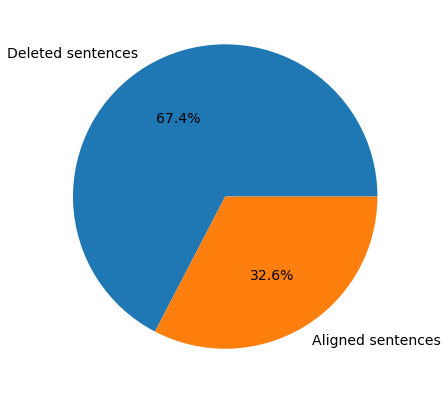

In [6]:
%%time
#For the concatenated dataframe
calculate_percentage_deleted_sentences(df_dataset)

# of normal sentences in the dataframe  9618942
# of simplfied sentences in the dataframe  1228635
# of deleted sentences in the dataframe  6309545
Percentage of deleted sentences 65.59
CPU times: user 42.8 s, sys: 0 ns, total: 42.8 s
Wall time: 42.8 s


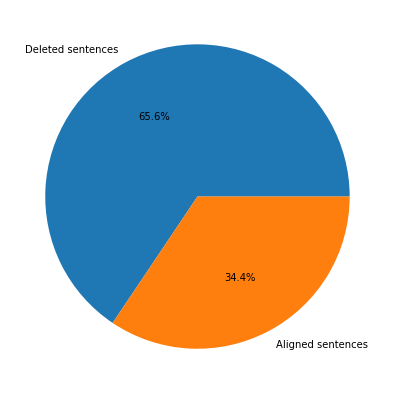

In [27]:
%%time
#For the first wiki_1 part
calculate_percentage_deleted_sentences(df_wiki_part_1)

# of normal sentences in the dataframe  525534
# of simplfied sentences in the dataframe  13036
# of deleted sentences in the dataframe  524564
Percentage of deleted sentences 99.82
CPU times: user 5.31 s, sys: 0 ns, total: 5.31 s
Wall time: 5.31 s


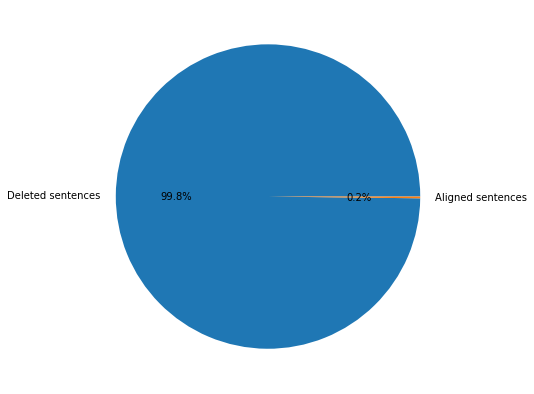

In [28]:
%%time
#For the first wiki_2 part
calculate_percentage_deleted_sentences(df_wiki_part_2)

# Process wiki-auto data to generate `.src` and `.dst` files for simplification

In [62]:
def generate_data_req_format(df_dataset, data_folder):
	size = len(df_dataset)
	skipped_articles = []
	skip_len = 0
	for i in range(size):
		# get article id
		normal_article_id = str(df_dataset['normal'][i]['id'])

		# get normal and simple sentences
		normal_list = list(df_dataset['normal'][i]['content'].values())
		simple_list = list(df_dataset['simple'][i]['content'].values())
		
		# skip article processing if below threshold of ~50%
		if len(normal_list) <= 5 or len(simple_list) < (len(normal_list) // 2) + 1:
			skipped_articles.append(normal_article_id)
			skip_len += 1
			continue
		
		# create {data_folder}/{article_id}
		output_dir = os.path.join(data_folder, normal_article_id)
		os.makedirs(output_dir, exist_ok=True)


		normal_content = '\n'.join(normal_list)
		simple_content = '\n'.join(simple_list)
		
		normal = os.path.join(output_dir, 'source.txt')
		simple = os.path.join(output_dir, 'destination.txt')
		
		with open(normal, 'w', encoding="utf-8") as normal_f, open(simple, 'w', encoding="utf-8") as simple_f:
			normal_f.write(normal_content)
			simple_f.write(simple_content)
		
		print(f'Done generating files for {i+1}/{size} articles. Skipping {skip_len} articles\r', end='', flush=True)
	print()
	print(skip_len)
	return skipped_articles

In [1]:
%%time
# !rm -rf 'data/wiki-auto'
data_folder = 'data/wiki-auto'
skipped_articles = generate_data_req_format(df_dataset, data_folder)

print(f'Done creating data in {data_folder}')
print(f'Total amount of generated articles  {len(df_dataset) - len(skipped_articles)}')



CPU times: user 48 ms, sys: 19.3 ms, total: 67.3 ms
Wall time: 3.95 s


#### Calculate average document length in normal and simple articles 

In [74]:
%%time
data_dir = 'data/wiki-auto'

count = 2
# base data/wiki-auto
normal_lengths_list = []
normal_count = 0

simple_count = 0
simple_lengths_list = []
for folder in os.listdir(data_dir):
    # print(folder)
    # raw data = data/wiki-auto/{id}
    base_data_dir = os.path.join(data_dir, folder)
    normal_article_file_path = os.path.join(base_data_dir, 'source.txt')
    simple_article_file_path = os.path.join(base_data_dir, 'destination.txt')

    with open(normal_article_file_path, 'r') as inputfile:
        total_lines = inputfile.readlines()
        normal_lengths_list.append(len(total_lines))
        normal_count += len(total_lines)

    with open(simple_article_file_path, 'r') as inputfile:
        total_lines = inputfile.readlines()
        simple_lengths_list.append(len(total_lines))
        simple_count += len(total_lines)

    # count -= 1
    # if count == 0:
    #     break
print("Normal ", len(normal_lengths_list))    
print("Simple ", len(simple_lengths_list))
print("normal count", normal_count)
print("simple count", simple_count)
print("Average normal articles length (sentences) ", sum(normal_lengths_list)/len(os.listdir(data_dir)))
print("Average simple articles length (sentences)", sum(simple_lengths_list)/len(os.listdir(data_dir)))


Normal  500
Simple  500
normal count 39093
simple count 29926
Average normal articles length (sentences)  78.186
Average simple articles length (sentences) 59.852
CPU times: user 155 ms, sys: 102 ms, total: 257 ms
Wall time: 414 ms


In [36]:
# Old code could be deleted at the end
# directory = 'data/wiki-auto'
# one_sentence_source_articles = 0
# one_sentence_destination_articles = 0
# for direc in os.listdir(directory):
#     for root, dirs, files in os.walk(os.path.join(directory,direc)):
#         with open(os.path.join(directory,direc,files[0]),'r') as destination, open(os.path.join(directory,direc,files[1]),'r') as source:
#             dest_lines = destination.readlines()
#             source_lines = source.readlines()
#             if len(dest_lines) <= 3:
#                 one_sentence_destination_articles +=1
#             if len(source_lines) == 3:
#                 one_sentence_source_articles +=1
#                 # print(os.path.join(directory,direc))

# print("Destination articles with #3 sentence", one_sentence_destination_articles)
# print("Source articles with #1 sentence", one_sentence_source_articles)



# '''
# leave it here for now!
# This function is used to convert the structure of the json files to group the data by [simple, normal, sentence_alignment]
# '''
# def reformat_json_file(input_file, outpu_file):
#     input_json_file = open(input_file,'r')
#     input_data = json.load(input_json_file)
#     input_json_file.close()
#     data_list = []
#     for key,value in input_data.items():
#         data_list.append(value)

#     output_json_file = open(outpu_file,"w")
#     output_data = json.dumps(data_list)
#     output_json_file.write(output_data)
#     output_json_file.close()
#     print("finished")

# # This is a test TO BE USED AS TEST
# df_dataset = pandas.read_json(
#     'wiki_test.json',
#     encoding='utf8',
#     orient='index'
# )

# # Convert the list of lists sentence_alignment and paragraph_alignment into a list of tuples
# df_dataset.sentence_alignment = df_dataset.sentence_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list if len(alignment_list)> 0])
# df_dataset.paragraph_alignment = df_dataset.paragraph_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list if len(alignment_list)> 0])
# df_dataset.head(10)    

Destination articles with #1 sentence 765
Source articles with #1 sentence 0
